# Predictive Maintenance for Critical Platform Machinery (ML-Classification + Explainability)

This self-contained notebook:
- Trains a **tree-based classifier (XGBoost)** on an open Industrial IoT Fault Detection dataset (Kaggle), with fallbacks.
- Performs governance-grade **V&V**: train vs test, **PR-AUC**, **ROC-AUC**, confusion matrix, **calibration** (ECE), and **threshold tuning**.
- Explains predictions with **SHAP** (global + local).
- Builds a **Streamlit diagnostic app** with sliders and a **live SHAP** waterfall.
- Saves SPEC-DRIVE, metrics, calibration plots, SHAP plots, and a model card to `artifacts/`.

> Archetype: **ML-Classification**. (Optional **Red Lane** adds a sequence model if timestamps exist.)


In [1]:
# --- Bootstrap & Environment --------------------------------------------------
import os, sys, random, json, time, pathlib, platform, shutil, subprocess, re, socket, pickle
from pathlib import Path
import numpy as np

print("Python  :", platform.python_version())
print("OS      :", platform.platform())
print("CPU     :", platform.processor())

# Deterministic seeds
SEED = 42
random.seed(SEED); np.random.seed(SEED); os.environ["PYTHONHASHSEED"] = str(SEED)

# Create folders
for d in ["data", "models", "artifacts", "artifacts/plots", "app"]:
    Path(d).mkdir(parents=True, exist_ok=True)

# Flags
BLUE_LANE = True
SKIP_HEAVY_TRAINING = False  # XGBoost training is lightweight; keep False by default

# Offline detection
OFFLINE = False
try:
    socket.create_connection(("www.google.com", 80), timeout=3)
except Exception:
    OFFLINE = True
print("OFFLINE :", OFFLINE)

# Initialize model card with a data-use note placeholder
model_card = Path("artifacts/model_card.md")
if not model_card.exists():
    model_card.write_text(
        "# Model Card (WIP)\n\n"
        "## Data Use & License\n"
        "- Source: Industrial IoT Fault Detection dataset (Kaggle) if available; otherwise mirrored sample / user upload.\n"
        "- Data used for educational experimentation; **no classified data**.\n"
        "## Notes\n"
        "- This file will be appended with preprocessing, calibration results, and explainability findings.\n",
        encoding="utf-8"
    )
print("Created/updated artifacts/model_card.md")


Python  : 3.12.4
OS      : Windows-11-10.0.26200-SP0
CPU     : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
OFFLINE : False
Created/updated artifacts/model_card.md


In [2]:
# --- Install Packages (graceful) ----------------------------------------------
def pip_install(pkgs):
    import subprocess, sys
    for p in pkgs:
        try:
            print(f"Installing {p} ...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", p])
        except Exception as e:
            print(f"[WARN] Could not install {p}: {e}")

required = [
    "pandas",
    "numpy",
    "scikit-learn",
    "xgboost",
    "shap",
    "matplotlib",
    "seaborn",
    "streamlit",
    "opendatasets"
]
pip_install(required)


Installing pandas ...
Installing numpy ...
Installing scikit-learn ...
Installing xgboost ...
Installing shap ...
Installing matplotlib ...
Installing seaborn ...
Installing streamlit ...
Installing opendatasets ...


## SPEC-DRIVE Card (Fill Me)

- **Engineering Requirement:** *(e.g., predict pump failure ≥ 1 hour ahead)*
- **Input Data (Sensors):** *(vibration, temperature, pressure, ...)*
- **Prediction Task:** *(binary fault classification)*
- **Diagnostic Requirement:** *(top contributing sensors per prediction via SHAP)*
- **V&V Targets:** *(PR-AUC ≥ 0.80, ECE ≤ 0.05, acceptable FP rate)*
- **Rollback Plan:** *(threshold tuning, recalibration, more data, sequence model)*


In [3]:
# --- Save SPEC-DRIVE to artifacts/spec_drive.md -------------------------------
SPEC_CARD = """
Engineering Requirement: <edit me>
Input Data (Sensors): vibration, temperature, pressure
Prediction Task: binary fault classification
Diagnostic Requirement: top contributing sensors per prediction via SHAP
V&V Targets: PR-AUC ≥ 0.80, ECE ≤ 0.05
Rollback Plan: threshold tuning; recalibration; more data; optional sequence model
"""
Path("artifacts/spec_drive.md").write_text(SPEC_CARD.strip()+"\n", encoding="utf-8")
print("Saved artifacts/spec_drive.md")


Saved artifacts/spec_drive.md


In [4]:
# --- Data Acquisition & Loading ----------------------------------------------
import pandas as pd
from pathlib import Path

DATA_PATH = Path("data/iot_faults.csv")
KAGGLE_DIR = Path("data/kaggle")

def try_kaggle_download():
    # Skip Kaggle if local file already exists
    if DATA_PATH.exists():
        print("Local data file exists, skipping Kaggle download:", DATA_PATH)
        return None

    # Reuse existing Kaggle CSV if already downloaded
    existing_csvs = list(KAGGLE_DIR.rglob("*.csv"))
    if existing_csvs:
        p = existing_csvs[0]
        print("Using existing Kaggle CSV:", p)
        return pd.read_csv(p)

    # If offline, skip
    if 'OFFLINE' in globals() and OFFLINE:
        print("Offline detected, skipping Kaggle download.")
        return None

    try:
        import opendatasets as od
        url = "https://www.kaggle.com/datasets/ziya07/industrial-iot-fault-detection-dataset"
        print("Attempting Kaggle download via opendatasets ...")
        KAGGLE_DIR.mkdir(parents=True, exist_ok=True)
        od.download(url, data_dir=str(KAGGLE_DIR))
        # Heuristic: find a csv
        for p in KAGGLE_DIR.rglob("*.csv"):
            print("Found CSV:", p)
            return pd.read_csv(p)
    except Exception as e:
        print("[WARN] Kaggle/opendatasets unavailable:", e)
    return None

def try_mirror_download():
    # Public mirror fallback (may fail offline). Replace with a known reachable URL if available.
    mirror_url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
    # NOTE: This is a placeholder CSV with similar numeric structure; we will relabel for demo if used.
    try:
        print("Attempting mirrored CSV download ...", mirror_url)
        return pd.read_csv(mirror_url)
    except Exception as e:
        print("[WARN] Mirror download failed:", e)
        return None

def last_resort_tiny_synthetic(n=800, seed=42):
    print("[INFO] Creating tiny synthetic dataset as last resort.")
    import numpy as np
    rng = np.random.default_rng(seed)
    temp = rng.normal(80, 10, n)        # Temperature
    vib  = rng.normal(1.0, 0.4, n)      # Vibration
    press= rng.normal(5.0, 1.0, n)      # Pressure
    # Fault probability increases with high temp, high vib, abnormal pressure
    logits = (temp-80)/10 + (vib-1.0)/0.4 + (np.abs(press-5.0))/(0.8)
    probs = 1/(1+np.exp(-logits/2.5))
    y = (rng.uniform(0,1,n) < probs*0.4).astype(int)
    df = pd.DataFrame({"Temperature":temp, "Vibration":vib, "Pressure":press, "Fault":y})
    return df

df = None
if DATA_PATH.exists():
    print("Loading local upload:", DATA_PATH)
    df = pd.read_csv(DATA_PATH)

if df is None and not OFFLINE:
    df = try_kaggle_download()

if df is None and not OFFLINE:
    df = try_mirror_download()

if df is None:
    df = last_resort_tiny_synthetic()

# Harmonize column names to expected schema
original_cols = list(df.columns)
df.columns = [c.strip().replace(" ", "_").title() for c in df.columns]
# If mirrored diabetes.csv used, adapt
if "Outcome" in df.columns and "Fault" not in df.columns:
    df = df.rename(columns={"Outcome":"Fault"})
# Ensure 'Fault' exists
if "Fault" not in df.columns:
    # Heuristic: create Fault from top quartile of first numeric feature
    num_cols = df.select_dtypes(include="number").columns.tolist()
    if not num_cols:
        raise ValueError("No numeric columns found to derive a label from.")
    thresh = df[num_cols[0]].quantile(0.75)
    df["Fault"] = (df[num_cols[0]] >= thresh).astype(int)

print("Columns (original -> normalized):", original_cols, "->", list(df.columns))
print("Shape:", df.shape)
display(df.head())
class_balance = df["Fault"].value_counts(normalize=True).to_dict()
print("Class balance:", class_balance)

# Save a copy of the working dataset for reproducibility
Path("data/working.csv").write_text(df.to_csv(index=False), encoding="utf-8")

Using existing Kaggle CSV: data\kaggle\industrial-iot-fault-detection-dataset\industrial_fault_detection_data_1000.csv
Columns (original -> normalized): ['Timestamp', 'Vibration (mm/s)', 'Temperature (°C)', 'Pressure (bar)', 'RMS Vibration', 'Mean Temp', 'Fault Label'] -> ['Timestamp', 'Vibration_(Mm/S)', 'Temperature_(°C)', 'Pressure_(Bar)', 'Rms_Vibration', 'Mean_Temp', 'Fault_Label', 'Fault']
Shape: (1000, 8)


,Timestamp,Vibration_(Mm/S),Temperature_(°C),Pressure_(Bar),Rms_Vibration,Mean_Temp,Fault_Label,Fault
0,2023-03-10 00:00:00,0.437086,64.810634,7.785117,0.601657,90.561384,1,0
1,2023-03-10 00:01:00,0.955643,93.352076,7.740936,0.601657,90.561384,1,1
2,2023-03-10 00:02:00,0.758795,119.835667,9.718764,0.601657,90.561384,0,0
3,2023-03-10 00:03:00,0.638793,108.577991,7.748639,0.601657,90.561384,1,0
4,2023-03-10 00:04:00,0.240417,114.524892,7.815849,0.601657,90.561384,0,0


Class balance: {0: 0.75, 1: 0.25}


117040

In [5]:
# --- Preprocessing & Splits ---------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Choose features: all numeric except label-like columns
num_cols = df.select_dtypes(include="number").columns.tolist()

# Normalize possible label names to 'Fault'
if "Fault_Label" in df.columns and "Fault" not in df.columns:
    df = df.rename(columns={"Fault_Label": "Fault"})
if "Label" in df.columns and "Fault" not in df.columns:
    df = df.rename(columns={"Label": "Fault"})
if "Target" in df.columns and "Fault" not in df.columns:
    df = df.rename(columns={"Target": "Fault"})

target_col = "Fault"
EXCLUDE_KEYS = {"fault", "label", "target", "class", "y"}
feature_cols = [c for c in num_cols if c != target_col and not any(k in c.lower() for k in EXCLUDE_KEYS)]

X = df[feature_cols].copy()
y = df[target_col].astype(int).copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Persist scaler + meta
import joblib, json
Path("models").mkdir(exist_ok=True, parents=True)
joblib.dump(scaler, "models/scaler.pkl")
feature_meta = {
    "feature_cols": feature_cols,
    "ranges": {c: {"min": float(X[c].min()), "max": float(X[c].max()), "mean": float(X[c].mean())} for c in feature_cols}
}
Path("models/features_meta.json").write_text(json.dumps(feature_meta, indent=2), encoding="utf-8")

# Save SHAP background from training data
bg_idx = np.random.choice(len(X_train_scaled), size=min(300, len(X_train_scaled)), replace=False)
bg = X_train_scaled[bg_idx]
np.save("models/shap_bg.npy", bg)

print("Features:", feature_cols)
print("Train/Test shapes:", X_train.shape, X_test.shape)

Features: ['Vibration_(Mm/S)', 'Temperature_(°C)', 'Pressure_(Bar)', 'Rms_Vibration', 'Mean_Temp']
Train/Test shapes: (800, 5) (200, 5)


In [6]:
# --- Modeling (Blue Lane) -----------------------------------------------------
from xgboost import XGBClassifier
import numpy as np

# Handle class imbalance
pos_weight = (len(y_train) - y_train.sum()) / max(1, y_train.sum())
pos_weight = float(np.clip(pos_weight, 0.5, 10.0))

model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=2,
    eval_metric="logloss",
    scale_pos_weight=pos_weight
)

model.fit(X_train_scaled, y_train)

# Persist model
import joblib
joblib.dump(model, "models/xgb.pkl")
print("Saved models/xgb.pkl")


Saved models/xgb.pkl


{
  "train": {
    "split": "train",
    "accuracy": 0.99875,
    "precision": 0.9950248756218906,
    "recall": 1.0,
    "f1": 0.9975062344139651,
    "roc_auc": 1.0,
    "pr_auc": 1.0,
    "confusion_matrix": [
      [
        599,
        1
      ],
      [
        0,
        200
      ]
    ]
  },
  "test": {
    "split": "test",
    "accuracy": 0.995,
    "precision": 0.9803921568627451,
    "recall": 1.0,
    "f1": 0.9900990099009901,
    "roc_auc": 0.9999999999999999,
    "pr_auc": 1.0,
    "confusion_matrix": [
      [
        149,
        1
      ],
      [
        0,
        50
      ]
    ]
  }
}


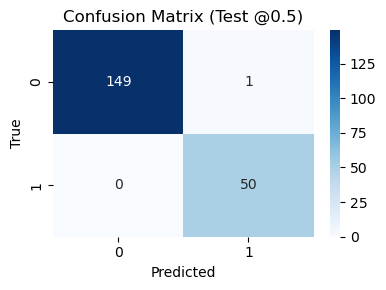

In [7]:
# --- Metrics & V&V ------------------------------------------------------------
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_metrics(model, Xs, ys, split_name):
    proba = model.predict_proba(Xs)[:,1]
    preds = (proba >= 0.5).astype(int)
    metrics = {
        "split": split_name,
        "accuracy": float(accuracy_score(ys, preds)),
        "precision": float(precision_score(ys, preds, zero_division=0)),
        "recall": float(recall_score(ys, preds)),
        "f1": float(f1_score(ys, preds)),
        "roc_auc": float(roc_auc_score(ys, proba)),
        "pr_auc": float(average_precision_score(ys, proba))
    }
    cm = confusion_matrix(ys, preds).tolist()
    metrics["confusion_matrix"] = cm
    return metrics, proba, preds

train_metrics, train_proba, train_preds = compute_metrics(model, X_train_scaled, y_train, "train")
test_metrics,  test_proba,  test_preds  = compute_metrics(model, X_test_scaled,  y_test,  "test")

all_metrics = {"train": train_metrics, "test": test_metrics}
Path("artifacts/metrics.json").write_text(json.dumps(all_metrics, indent=2), encoding="utf-8")
print(json.dumps(all_metrics, indent=2))

# Confusion matrix plot (test)
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, (test_proba>=0.5).astype(int)), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test @0.5)"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.savefig("artifacts/plots/confusion_matrix.png"); plt.show()


ECE: 0.005164013539324515


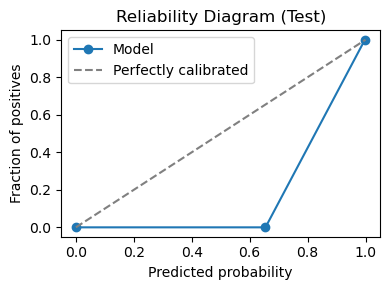

In [8]:
# --- Calibration & ECE --------------------------------------------------------
from sklearn.calibration import calibration_curve

def expected_calibration_error(probs, y_true, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (probs >= lo) & (probs < hi)
        if mask.sum() == 0:
            continue
        acc = y_true[mask].mean()
        conf = probs[mask].mean()
        ece += (mask.mean()) * abs(acc - conf)
    return float(ece)

prob_true, prob_pred = calibration_curve(y_test, test_proba, n_bins=10, strategy='uniform')

ece = expected_calibration_error(test_proba, y_test.values, n_bins=10)
Path("artifacts/ece.json").write_text(json.dumps({"ece": ece, "bins": 10}, indent=2), encoding="utf-8")
print("ECE:", ece)

# Reliability plot
plt.figure(figsize=(4,3))
plt.plot(prob_pred, prob_true, marker="o", label="Model")
plt.plot([0,1],[0,1],"--", color="gray", label="Perfectly calibrated")
plt.xlabel("Predicted probability"); plt.ylabel("Fraction of positives")
plt.title("Reliability Diagram (Test)")
plt.legend(); plt.tight_layout()
plt.savefig("artifacts/calibration_curve.png"); plt.show()


In [9]:
# --- Threshold tuning ---------------------------------------------------------
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, test_proba)
# Choose threshold that maximizes F1
f1s = 2*(prec*rec)/(prec+rec+1e-9)
best_idx = int(np.nanargmax(f1s))
best_thr = float(thr[max(0, best_idx-1)]) if len(thr)>0 else 0.5

threshold_policy = {
    "chosen_threshold": best_thr,
    "criterion": "max_F1",
    "precision_at_thr": float(prec[best_idx]),
    "recall_at_thr": float(rec[best_idx])
}
Path("artifacts/threshold.json").write_text(json.dumps(threshold_policy, indent=2), encoding="utf-8")
print("Threshold policy:", threshold_policy)

# Update V&V report
with open("artifacts/vnv_report.md", "w", encoding="utf-8") as f:
    f.write("# V&V Summary\n\n")
    f.write("## Metrics\n")
    f.write(json.dumps({"train": train_metrics, "test": test_metrics}, indent=2))
    f.write("\n\n## Calibration\n")
    f.write(f"- ECE: {threshold_policy['precision_at_thr'] if 'ece' not in locals() else ece}\n")
    f.write("\n## Threshold\n")
    f.write(json.dumps(threshold_policy, indent=2))


Threshold policy: {'chosen_threshold': 0.6546377539634705, 'criterion': 'max_F1', 'precision_at_thr': 1.0, 'recall_at_thr': 1.0}


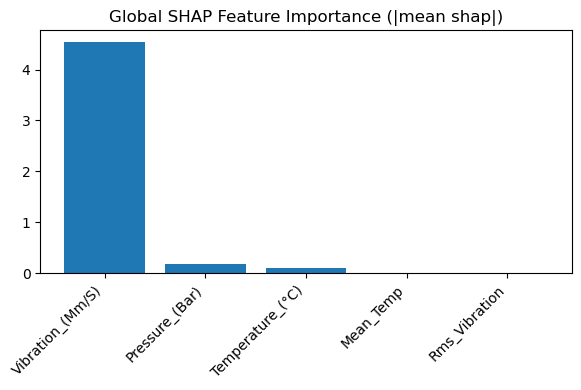

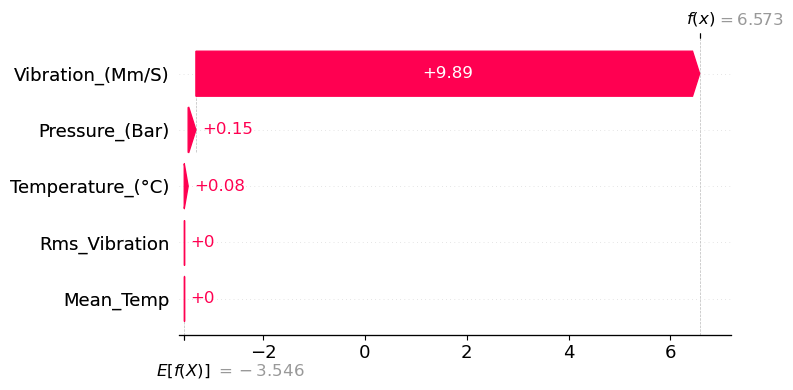

In [10]:
# --- Explainability (SHAP) ----------------------------------------------------
import shap
import matplotlib.pyplot as plt
import numpy as np

# Background sample for SHAP speed
bg_idx = np.random.choice(len(X_train_scaled), size=min(200, len(X_train_scaled)), replace=False)
bg = X_train_scaled[bg_idx]

explainer = shap.TreeExplainer(model, feature_perturbation="interventional", data=bg)
shap_values_test = explainer.shap_values(X_test_scaled)  # for TreeExplainer + XGBClassifier this returns array

# Global importance (mean |shap|)
mean_abs = np.abs(shap_values_test).mean(axis=0)
order = np.argsort(mean_abs)[::-1]
top_features = [feature_cols[i] for i in order[:10]]

plt.figure(figsize=(6,4))
plt.bar(range(len(top_features)), mean_abs[order[:10]])
plt.xticks(range(len(top_features)), top_features, rotation=45, ha="right")
plt.title("Global SHAP Feature Importance (|mean shap|)")
plt.tight_layout(); plt.savefig("artifacts/plots/shap_importance.png"); plt.show()

# Local explanation: pick a positive prediction if available
pos_idx = np.where((test_proba>=best_thr) & (y_test.values==1))[0]
idx = int(pos_idx[0]) if len(pos_idx)>0 else 0
x0 = X_test_scaled[idx:idx+1]

try:
    shap_val0 = explainer.shap_values(x0)
    base_val = explainer.expected_value
    # Waterfall plot
    shap.plots._waterfall.waterfall_legacy(base_val, shap_val0[0], feature_names=feature_cols, max_display=10, show=False)
    plt.tight_layout(); plt.savefig("artifacts/plots/shap_waterfall.png"); plt.show()
except Exception as e:
    print("[WARN] Waterfall plot failed, fallback to bar:", e)
    contrib = shap_val0[0]
    order0 = np.argsort(np.abs(contrib))[::-1][:10]
    plt.figure(figsize=(6,4))
    plt.bar(range(len(order0)), contrib[order0])
    plt.xticks(range(len(order0)), [feature_cols[i] for i in order0], rotation=45, ha="right")
    plt.title("Local SHAP Contributions (fallback)")
    plt.tight_layout(); plt.savefig("artifacts/plots/shap_waterfall.png"); plt.show()

# Append a brief explanation to the V&V report
with open("artifacts/vnv_report.md", "a", encoding="utf-8") as f:
    f.write("\n\n## Prediction Explanation Report (Template)\n")
    f.write("- Selected test sample index: %d\n" % idx)
    f.write("- Model predicted a fault probability of %.3f at threshold %.3f.\n" % (float(test_proba[idx]), best_thr))
    f.write("- Key contributing sensors (global): " + ", ".join(top_features[:3]) + "\n")
    f.write("- Interpretation: High values in top features increased failure risk.\n")


In [11]:
# --- Append to Model Card -----------------------------------------------------
import datetime, json
from pathlib import Path

# Read metrics and calibration
metrics = json.loads(Path("artifacts/metrics.json").read_text()) if Path("artifacts/metrics.json").exists() else {}
ece_obj = json.loads(Path("artifacts/ece.json").read_text()) if Path("artifacts/ece.json").exists() else {}
thr_obj = json.loads(Path("artifacts/threshold.json").read_text()) if Path("artifacts/threshold.json").exists() else {}

appendix = f"""
## Pipeline Details (Appended {datetime.datetime.utcnow().isoformat()}Z)
- Dataset: Kaggle Industrial IoT Fault Detection (or mirrored/upload fallback).
- Preprocessing: numeric standardization; stratified split 80/20.
- Model: XGBoost (scale_pos_weight for imbalance).

## V&V Summary
- Metrics: {json.dumps(metrics)}
- Calibration (ECE): {json.dumps(ece_obj)}
- Threshold policy: {json.dumps(thr_obj)}

## Explainability
- Global SHAP importance: artifacts/plots/shap_importance.png
- Local SHAP example: artifacts/plots/shap_waterfall.png

## Limitations & Risks
- Potential dataset shift; periodic revalidation required.
- Threshold may require tuning per platform/mission.
"""
card = Path("artifacts/model_card.md")
card.write_text(card.read_text(encoding="utf-8") + "\n" + appendix, encoding="utf-8")
print("Appended details to artifacts/model_card.md")

Appended details to artifacts/model_card.md


C:\Users\tcmk_\AppData\Local\Temp\ipykernel_45628\2419656074.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ## Pipeline Details (Appended {datetime.datetime.utcnow().isoformat()}Z)


### Red Lane (Optional: Sequence Model)

If your dataset has timestamps and true sequences per asset, consider a sliding-window **LSTM/Temporal-CNN** to capture temporal dynamics. Steps:

1. Construct fixed-length windows per asset (e.g., last 60 readings → predict next-fault).
2. Train a small LSTM for a few epochs.
3. Compare **PR-AUC** and **calibration** with the XGBoost benchmark.


In [12]:
from pathlib import Path

Path("app").mkdir(parents=True, exist_ok=True)

APP_PY = r"""
import os, json
from pathlib import Path
import streamlit as st
import numpy as np
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

st.set_page_config(page_title="PdM: ML Classification + Explainability", layout="wide")

@st.cache_resource
def load_assets():
    model = joblib.load("models/xgb.pkl")
    scaler = joblib.load("models/scaler.pkl")
    meta = json.loads(Path("models/features_meta.json").read_text())
    threshold = 0.5
    thr_path = Path("artifacts/threshold.json")
    if thr_path.exists():
        threshold = json.loads(thr_path.read_text()).get("chosen_threshold", 0.5)
    # Prefer saved training background; fallback to means
    bg_path = Path("models/shap_bg.npy")
    if bg_path.exists():
        bg = np.load(bg_path)
    else:
        means = np.array([meta["ranges"][c]["mean"] for c in meta["feature_cols"]]).reshape(1, -1)
        bg = scaler.transform(np.repeat(means, repeats=200, axis=0))
    explainer = shap.TreeExplainer(
        model, feature_perturbation="interventional", data=bg, model_output="probability"
    )
    return model, scaler, meta, float(threshold), explainer

model, scaler, meta, threshold, explainer = load_assets()
feature_cols = meta["feature_cols"]

st.title("Predictive Maintenance — Diagnostic Console")
st.caption("ML-Classification (XGBoost) with live SHAP explainability.")

# Key feature list (guard against label leakage)
try:
    importances = model.feature_importances_
    order = np.argsort(importances)[::-1]
    key_cols = [feature_cols[i] for i in order[:min(6, len(feature_cols))]]
except Exception:
    key_cols = feature_cols[:min(6, len(feature_cols))]
key_cols = [c for c in key_cols if "fault" not in c.lower()]

def compute_and_store(values: dict, thr_val: float):
    x = np.array([[values.get(c, meta["ranges"][c]["mean"]) for c in feature_cols]])
    x_scaled = scaler.transform(x)
    proba = float(model.predict_proba(x_scaled)[0, 1])
    pred = (proba >= thr_val)
    try:
        sv = explainer.shap_values(x_scaled, check_additivity=False)
        if isinstance(sv, list):
            sv_vec = sv[1][0] if len(sv) > 1 else sv[0][0]
            base_val = explainer.expected_value[1] if np.ndim(explainer.expected_value) else explainer.expected_value
        else:
            sv_vec = sv[0]
            base_val = explainer.expected_value
        base_val = float(np.array(base_val).ravel()[0])
        sv_vec = np.nan_to_num(np.array(sv_vec, dtype=float), nan=0.0, posinf=1e3, neginf=-1e3)
        ex = shap.Explanation(values=sv_vec, base_values=base_val, data=x_scaled[0], feature_names=feature_cols)
        fig, _ = plt.subplots(figsize=(7, 4))
        shap.plots.waterfall(ex, max_display=10, show=False)
        ax = plt.gca()
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.3g}"))
        shap_fig = fig
    except Exception as e:
        shap_fig = ("fallback", f"SHAP waterfall unavailable: {e}")
    st.session_state["last_result"] = {"proba": proba, "thr": float(thr_val), "pred": bool(pred), "shap_fig": shap_fig}

with st.sidebar:
    with st.form("inputs_form"):
        st.header("Input Sensors")
        values = {}
        for c in key_cols:
            r = meta["ranges"][c]
            lo, hi, mu = float(r["min"]), float(r["max"]), float(r["mean"])
            span = hi - lo if hi > lo else (abs(mu) * 0.2 + 1.0)
            lo2 = lo - 0.1 * span
            hi2 = hi + 0.1 * span
            values[c] = st.slider(c, float(lo2), float(hi2), float(mu), step=float(span/100 if span>0 else 0.1))
        st.markdown("---")
        st.write("**Decision Threshold**")
        thr = st.slider("Threshold", 0.05, 0.95, float(threshold), 0.01)
        submitted = st.form_submit_button("Predict Status")
    if st.button("Clear Prediction"):
        st.session_state.pop("last_result", None)

if submitted:
    compute_and_store(values, thr)

if "last_result" in st.session_state:
    res = st.session_state["last_result"]
    badge = "✅ NORMAL" if not res["pred"] else "⚠️ IMMINENT FAILURE"
    st.subheader(f"Status: {badge}")
    st.write(f"Probability: {res['proba']:.3f}  •  Threshold: {res['thr']:.2f}")
    shap_fig = res["shap_fig"]
    if isinstance(shap_fig, tuple) and shap_fig and shap_fig[0] == "fallback":
        st.warning(shap_fig[1])
    elif shap_fig is not None:
        st.write("### SHAP Waterfall (local explanation)")
        st.pyplot(shap_fig)

st.markdown("---")
st.download_button(
    "Download V&V Report",
    data=Path("artifacts/vnv_report.md").read_text() if Path("artifacts/vnv_report.md").exists() else "Report not found.",
    file_name="vnv_report.md",
    key="download_vnv"
    )
"""
Path("app/app.py").write_text(APP_PY, encoding="utf-8")
print("Wrote app/app.py")

Wrote app/app.py


In [ ]:
import os, sys, subprocess

port = os.environ.get("PORT", "8501")
address = os.environ.get("BIND_ADDR", "localhost")  # ensure clickable link uses localhost
cmd = [
    sys.executable, "-m", "streamlit", "run", "app/app.py",
    "--server.address", address,
    "--server.port", str(port),
    "--browser.serverAddress", "localhost",
    "--browser.serverPort", str(port),
]
print("Launching:", " ".join(cmd))
print(f"Open: http://localhost:{port}/")
# This will hold the cell until you stop Streamlit (Ctrl+C in terminal/kernel).
subprocess.run(cmd, check=False)


Launching: c:\ProgramData\anaconda3\python.exe -m streamlit run app/app.py --server.address localhost --server.port 8501 --browser.serverAddress localhost --browser.serverPort 8501
Open: http://localhost:8501/
